### Download input data from drive.google.com

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls /content/gdrive/'My Drive'/nlp-project/input

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
ria_1k_.json  ria_1k.json  ria_20.json	ria.json.gz


In [2]:
!cp -r /content/gdrive/'My Drive'/nlp-project/input ./input/
!cp -r /content/gdrive/'My Drive'/nlp-project/src ./src
!ls /content/input/
!ls /content/src/

ria_1k_.json  ria_1k.json  ria_20.json	ria.json.gz
model.py  params.py  test.py  train.py	utils.py


# Generation of headlines for news articles in Russian with a sequence to sequence network and attention¶
```
1 Data Preparation
2 Exploring dataset
3  Model Implementation
    3.1  Encoder
    3.2  Decoder with Attention
3  Training Seq2Seq
4  Evaluating Seq2Seq
5  Summary
 Reference
```

### Requirements

In [3]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

import os
import re
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'USE_CUDA={device}')

USE_CUDA=cuda


## Loading Data - read data files

In [4]:
data_path = 'input/ria_1k.json'
glove_path = 'input/glove.6B.50d.txt'
data = pd.read_json(data_path, lines=True)
print(f'raw text = {data["text"][1]}\nraw title = [{data["title"][1]}]')
data.head(3)

raw text = <p><strong></strong></p>
<p><strong>москва, 2 дек&nbsp;&mdash; риа новости.</strong> цена на&nbsp;нефть марки brent, ранее в&nbsp;понедельник падавшая до&nbsp;пятилетних минимумов, поднялась выше психологической отметки в&nbsp;73 доллара за&nbsp;баррель, свидетельствуют данные торгов.</p>
<p><img src="/img/article_icon.gif" border="0" hspace="5" width="20" height="20" tag="[-json: {'type':'article','article_id':'1036106874'}-]" />по состоянию на&nbsp;12.10 мск стоимость фьючерсов на&nbsp;североморскую смесь brent растет на&nbsp;0,5%&nbsp;&mdash; до&nbsp;72,88 доллара за&nbsp;баррель и&nbsp;уже поднималась до&nbsp;73,03 доллара. стоимость январских фьючерсов на&nbsp;легкую нефть марки wti снижалась на&nbsp;0,1%&nbsp;&mdash; до&nbsp;68,95 доллара за&nbsp;баррель.</p>
<p>ранее в&nbsp;ходе торгов фьючерсы на&nbsp;brent и&nbsp;wti дешевели до&nbsp;67,53 и&nbsp;63,72 доллара за&nbsp;баррель соответственно&nbsp;&mdash; минимумов с&nbsp;октября и&nbsp;июля 2009 года.</p>
<p>в четвер

,text,title
0,<p><strong>автор мария балябина <br /></strong...,украинская люстрация: жертвоприношение во власти
1,"<p><strong></strong></p>\n<p><strong>москва, 2...",цена на нефть марки brent поднялась выше $73 з...
2,"<p><strong></strong></p>\n<p><strong>бангкок, ...",число пострадавших в аварии в таиланде россиян...


## 1 Data Preparation
split the sentences into words and convert it into One-Hot Vector.
Each word will be indexed in the Lang class to make a dictionary. The Lang Class will store every text and split it word by word with the addSentence. Then create a dictionary by indexing every unknown word.

### Indexing words
class Lang has 
- word → index: (word2index) dictionary
- index → word: (index2word) dictionary,
- word2count: count of each word to use to

```
# This is formatted as code
```

 later replace rare words.

In [0]:
SOS_token = 0
EOS_token = 1

#initialize Lang Class
class Lang:
    def __init__(self):
        #initialize containers to hold the words and corresponding index
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS

    #split a sentence into words and add it to the container
    def addSentence(self, sentence):
       for word in sentence.split(' '):
           self.addWord(word)

    #If the word is not in the container, the word will be added to it, 
    #else, update the word counter
    def addWord(self, word):
       if word not in self.word2index:
           self.word2index[word] = self.n_words
           self.word2count[word] = 1
           self.index2word[self.n_words] = word
           self.n_words += 1
       else:
           self.word2count[word] += 1

The Lang Class help us make a dictionary. For each text and title, every sentence will be split into words and then added to the container. Each container will store the words in the appropriate index, count the word, and add the index of the word so we can use it to find the index of a word or finding a word from its index.

We have dataFrame with source texts and target titles. For every sentence we will
- normalize it to lower case,
- remove all non-character
- split the sentences, so have each word in it.

In [6]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r'\b\d+\b', ' ',text)
    text = re.sub(r'\(.*\)',' ',text)
    text = re.sub(r'[^а-яА-Я0-9. ]',' ',text)
    text = re.sub(r'(\s+.\s+)',' ',text)
    text = re.sub(r'\.',' . ',text)
    text = re.sub(r'^(\b\w+\b\s{,2}){,5}\.',' ',text)
    text = ' '.join(text.split())
    return text

def normalize_sentence(df, lang):
    clean_text = []
    for text in df[lang]:
        clean_text.append(clear_text(text))
    return pd.Series(data=clean_text, name=lang)

def read_sentence(df, lang1, lang2):
    sentence1 = normalize_sentence(df, lang1)
    sentence2 = normalize_sentence(df, lang2)
    return sentence1, sentence2

def read_file(loc, lang1, lang2):
   df = pd.read_json(loc, lines=True)
   return df


df = read_file(loc='input/ria_1k.json', lang1='text', lang2='title')
sentence1, sentence2 = read_sentence(df, lang1='text', lang2='title')
text_max_lenght = max([len(text.split()) for text in sentence1])
print(f'the article with maximum letngth has {text_max_lenght} tokens')

the article with maximum letngth has 20097 tokens


In [7]:
MAX_LENGTH = text_max_lenght+1

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


def process_data(lang1,lang2):
    data_path = 'input/ria_1k.json'
#    lang1, lang2 = ('text', 'title')

    df = read_file(loc=data_path, lang1='text', lang2='title')
    print(f"Read {len(df)} sentence pairs")

    sentence1, sentence2 = read_sentence(df, lang1, lang2)
    pairs = list(zip(sentence1,sentence2))
    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")

    lang = Lang()
    # pairs = []
    for pair in pairs:
        lang.addSentence(pair[0]+' '+pair[1])

    return lang, pairs

lang, pairs = process_data(lang1='text' ,lang2='title')

Read 1000 sentence pairs
Trimmed to 1000 sentence pairs
Counting words...


## 2 Exploring dataset

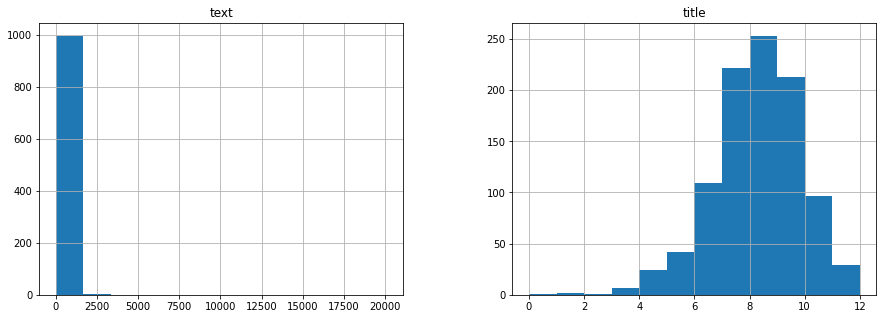

87.80% of texts have < 300 words
100.00% of titles have < 12 words


In [8]:
import matplotlib.pyplot as plt
def get_wors_stat():
    # length distribution
    text_count = []
    summary_count = []
    for sent in text:
        text_count.append(len(sent.split()))
    for sent in title:
        summary_count.append(len(sent.split()))

    graph_df= pd.DataFrame()
    graph_df['text']=text_count
    graph_df['title']=summary_count

    graph_df.hist(bins = 12,figsize=(15,5))
    plt.show()
    return

def get_text_share(text, label, threshold):
    cnt=0
    for i in text:
        if(len(i.split())<=threshold):
            cnt=cnt+1
    print(f'{cnt/len(text):.2%} of {label}s have < {threshold} words')


text, title = [], []
for pair in pairs:
    text.append(pair[0])
    title.append(pair[1])
get_wors_stat()
get_text_share(text,'text', 300)
get_text_share(title,'title', 12)

Because there are texts of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

To train the network quickly, we will cut out the largest texts, while preserving the bulk of the dataset.

In [9]:
MAX_LENGTH = 300
# Now reinitialize the dictionary and recreate the container with texts and titles
lang, pairs = process_data(lang1='text' ,lang2='title')

Read 1000 sentence pairs
Trimmed to 877 sentence pairs
Counting words...


## 3  Model Implementation
Unlike sequence prediction with one RNN, the seq2seq model frees us from the length and order of the sequence, which is suitable for summarizing texts.



In [10]:
lang, pairs = process_data(lang1='text' ,lang2='title')

Read 1000 sentence pairs
Trimmed to 877 sentence pairs
Counting words...


###    3.1  Encoder


In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


###    3.3  Decoder with Attention

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

##    4 Training Seq2Seq
### Preparing Training Data
converting pairs into Tensor is very important because our network only reads tensors.

at every end of the text there will be a token to tell the network that the input is finished. For every word in the text, it will get the index from the appropriate word in the dictionary and add a token at the end of the text.



In [13]:
def indexesFromSentence(lang, sentence):
   return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
   indexes = indexesFromSentence(lang, sentence)
   indexes.append(EOS_token)
   return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair, input_lang=lang, output_lang=lang):
   input_tensor = tensorFromSentence(input_lang, pair[0])
   target_tensor = tensorFromSentence(output_lang, pair[1])
   return (input_tensor, target_tensor)

i=0
print(f'pait No {i} => input tenzor={tensorsFromPair(pairs[i])[0].shape}, output tenzor={tensorsFromPair(pairs[i])[1].shape}')

pait No 0 => input tenzor=torch.Size([112, 1]), output tenzor=torch.Size([9, 1])


### 4.1 Training the Model

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [0]:
# This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### 4.2 Plotting results

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure(figsize=(12,9))
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


### 4.3 Evaluation
Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.



In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### 4.4 Training and Evaluating

28m 8s (- 394m 1s) (5000 6%) 6.4459
56m 5s (- 364m 36s) (10000 13%) 5.1317
83m 38s (- 334m 35s) (15000 20%) 3.0157
110m 41s (- 304m 24s) (20000 26%) 1.2505
137m 22s (- 274m 44s) (25000 33%) 0.5860
163m 2s (- 244m 33s) (30000 40%) 0.4048
187m 48s (- 214m 38s) (35000 46%) 0.2851
212m 42s (- 186m 7s) (40000 53%) 0.2055
237m 40s (- 158m 26s) (45000 60%) 0.1449
262m 38s (- 131m 19s) (50000 66%) 0.1035
287m 25s (- 104m 31s) (55000 73%) 0.0618
312m 24s (- 78m 6s) (60000 80%) 0.0518
337m 3s (- 51m 51s) (65000 86%) 0.0357
361m 45s (- 25m 50s) (70000 93%) 0.0277
386m 30s (- 0m 0s) (75000 100%) 0.0239


<Figure size 432x288 with 0 Axes>

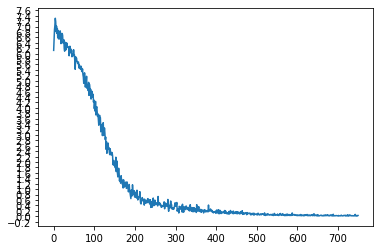

In [20]:
hidden_size = 256
encoder1 = EncoderRNN(lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

As one can below, the network simply memorized the training data set.

It is necessary to split the dataset and test the network on data unseen before.

In [55]:
# path = "/content/gdrive/'My Drive'/nlp-project"
# torch.save(encoder1,"encoder1.pth")
# torch.save(attn_decoder1,"attn_decoder1.pth")


evaluateRandomly(encoder1, attn_decoder1)


> бишкек дек риа новости . президент киргизии посетит саудовскую аравию объединенные арабские эмираты катар для обсуждения перспектив развития сотрудничества этими странами сообщил риа новости во вторник представитель пресс службы главы киргизии . президент алмазбек атамбаев со второго по восьмое декабря посетит официальными визитами королевство саудовская аравия объединенные арабские эмираты катар где проведет встречи высшим руководством стран на которых будут обсуждены состояние перспективы двусторонних отношений политической торгово экономической культурно гуманитарной сферах сказал собеседник агентства . рамках визитов запланировано подписание ряда двусторонних документов направленных на развитие сотрудничества торгово экономической инвестиционной культурно гуманитарной других сферах . посещения главы киргизского государства саудовской аравии объединенных арабских эмиратов катара станут первыми истории двустороннего сотрудничества визитами высокого уровня которые призваны придать н

# Visualizing Attention


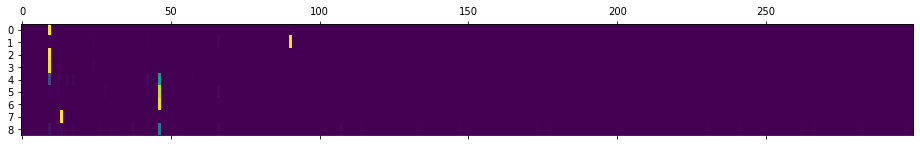

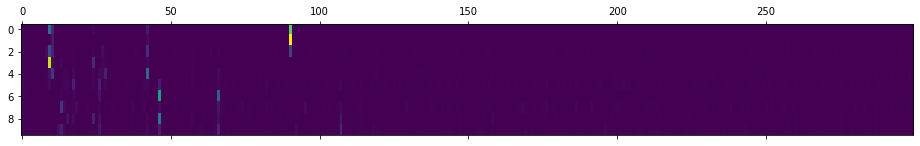

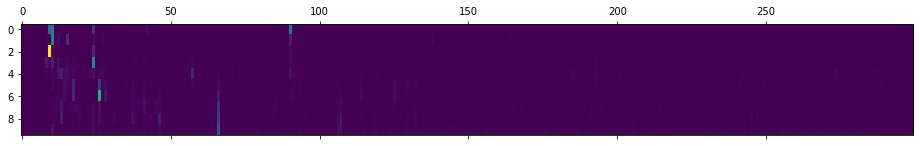

In [54]:
for i in range(3):
    pair = random.choice(pairs)
    output_words, attentions = evaluate(encoder1, attn_decoder1, pair[0])
    plt.matshow(attentions.numpy(), aspect='auto')

For a better viewing experience we will do the extra work of adding axes and labels:

input = анкара дек риа новости ал на палажченко . восемь документов подписаны между россией турцией по итогам государственного визита президента рф владимира путина турцию . анкаре прошло пятое заседание совета сотрудничества высшего уровня между российской федерацией турецкой республикой российскую делегацию возглавил президент владимир путин турецкую президент реджеп тайип эрдоган . предыдущее четвертое заседание ссву состоялось ноября года санкт петербурге . помимо меморандума взаимопонимании между газпромом турецким концерном подписан меморандум взаимопонимании между российским энергетическим агентством минэнерго минэнерго турции области энергоэффективности энергосбережения возобновляемых источников энергии . подписан меморандум взаимопонимании между росатомом минэнерго турции подготовке кадров для атомной отрасли смежных отраслей . кроме этого подписан протокол го заседания смешанной российско турецкой межправкомиссии по торгово экономическому сотрудничеству . подписано совместное

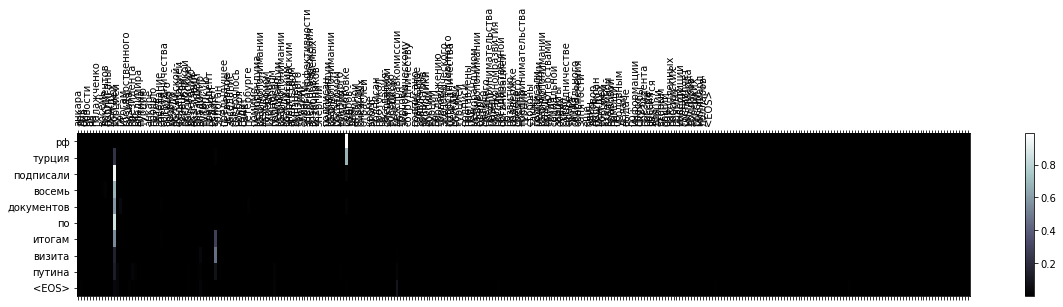

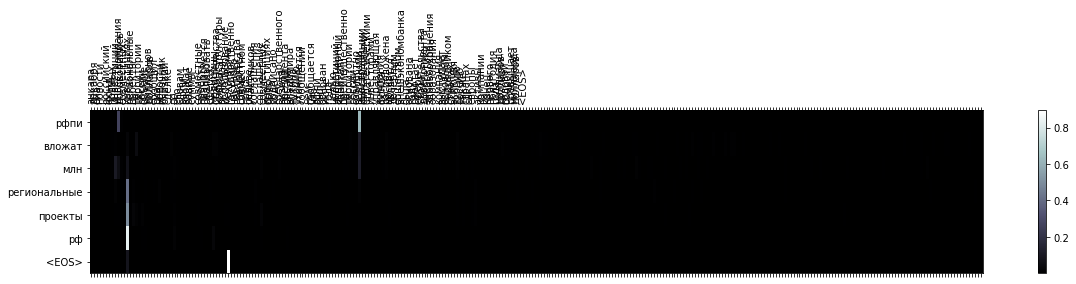

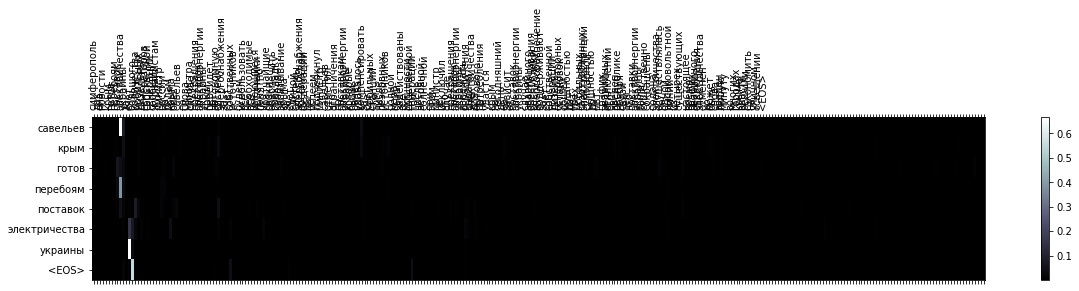

In [63]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,3))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


for i in range(3):
    evaluateAndShowAttention(random.choice(pairs)[0])

In [58]:
random.choice(pairs)[0]

'тбилиси дек риа новости мэги кикалейшвили . президент грузии георгий маргвелашвили подписал воскресенье закон тайном прослушивании согласно которому мвд сохраняет за собой право прямого доступа персональным данным заявил руководитель администрации главы государства давид патарая . парламент утвердил пятницу трех чтениях поправки ряд законов прослушивании несмотря на протест оппозиции части депутатов от большинства . согласно поправкам право тайного прослушивания сохраняет за собой мвд инспектор защиты персональных данных осуществляет надзор . премьер грузии ираклий гарибашвили поддержал поправки . позже президент грузии наложил вето на принятый пакет законов предложил парламенту новый вариант законопроектов котором полномочия выдавать разрешение на осуществление конкретного прослушивания будут суда наблюдать за этими процессами будет инспектор защиты персональных данных . парламент воскресенье преодолел вето президента голосом оставил силе первоначальный вариант законопроекта . презид

## 5 ROUGE Score Evaluation

To assess the quality of the model, ROUGE metric is used. It measures n-gram overlap between predicted headlines and gold labels. R-1, R-2, R-L scores used here in terms of (p)recision $\frac{\#overlap}{\#predicted}$,
(r)ecall $\frac{\#overlap}{\#gold}$ and F1 $\frac{2· p · r}{p+r}$.

Relative Length measures the ratio between the length of predicted headlines and the gold labels $\frac{LenPredict}{LenGold}$.

A simple sample of how rouge can be calculated is here https://github.com/pcyin/PyRouge


 ## TODO further work
- use PyRouge for ROUGE Score Evaluation
- use pretrained word embedings
- use with more layers
- Get dataset from https://ru.investing.com/news/economy

# References:
1. Daniil Gavrilov, Pavel Kalaidin, and Valentin Malykh. Self-Attentive Model for Headline Generation. 41st European Conference on Information Retrieval, 2019. arXiv:1901.07786 
2. "Rossiya Segodnya" news dataset. https://github.com/RossiyaSegodnya/ria_news_dataset
3. NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION. https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
4. SEQ2SEQ WITH ATTENTION. https://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/deep_learning/seq2seq/2_torch_seq2seq_attention.ipynb
5. Auto-highlighter: extractive text summarization with sequence-to-sequence model. https://medium.com/@rimacyn_23654/auto-highlighter-extractive-text-summarization-with-sequence-to-sequence-model-cbbf333772bf